# Chapter 25: What the spec?

For additional context see chapter 25 of [The Virus of Variation & Process Behavior Charts: A Guide for the Perplexed](https://www.brokenquality.com/book).

In [92]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr
from process_improvement import limit_charts as lc
from process_improvement import comparison_charts as cc
from process_improvement import process_capability as pc

%matplotlib inline

## Get data

In [93]:
# Dataset URLs
aircraft_part_URL = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation-and-pbcs/refs/heads/main/data/25-aileron-and-elevator-data.csv'
part_length_URL = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation-and-pbcs/refs/heads/main/data/25-part-length-and-width-data.csv'

# Get data
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Generate dataframes
aircraft_parts_df = get_data(aircraft_part_URL)
part_lengths_df = get_data(part_length_URL)

In [94]:
# Specify dtypes
aircraft_parts_df['PartNumber'] = aircraft_parts_df['PartNumber'].astype('string')
aircraft_parts_df.head()

,PartName,Side,PartNumber,Weight (g),Target,USL,LSL
0,Aileron,Left,A1,867,867,870,864
1,Aileron,Left,A2,869,867,870,864
2,Aileron,Left,A3,868,867,870,864
3,Aileron,Left,A4,866,867,870,864
4,Aileron,Left,A5,868,867,870,864


In [95]:
# Specify dtypes
part_lengths_df['part_number'] = part_lengths_df['part_number'].astype('string')
part_lengths_df.head()

,part_number,x_actual,y_actual
0,1,218.97,136.99
1,2,219.00,137.01
2,3,218.95,136.98
3,4,218.99,137.00
4,5,219.05,137.01


### Split aircraft_parts_df into aileron_df and elevator_df

In [96]:
aileron_df = aircraft_parts_df[aircraft_parts_df['PartName'] == 'Aileron']
elevator_df = (aircraft_parts_df[aircraft_parts_df['PartName'] != 'Aileron']
               .reset_index(drop=True))
elevator_df.head()

,PartName,Side,PartNumber,Weight (g),Target,USL,LSL
0,Elevator,Left,E1,690,692,701,683
1,Elevator,Left,E2,693,692,701,683
2,Elevator,Left,E3,694,692,701,683
3,Elevator,Left,E4,691,692,701,683
4,Elevator,Left,E5,689,692,701,683


## Fig 25.2: X Chart of elevator weights

In [97]:
# Specify round_value
round_value = 0

# Specify tickinterval
tickinterval = 2

# Disaggregate the dataframe 
data = elevator_df["Weight (g)"]
moving_ranges = round(abs(data.diff()),round_value)
labels = elevator_df["PartNumber"]

# Add moving ranges to df as column
elevator_df = elevator_df.copy()
elevator_df['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
AmR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*AmR),round_value)
LPL = round(mean - (C1*AmR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*AmR,round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
mrchart_lines = [(AmR,'black'), (URL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(AmR,AmR)]

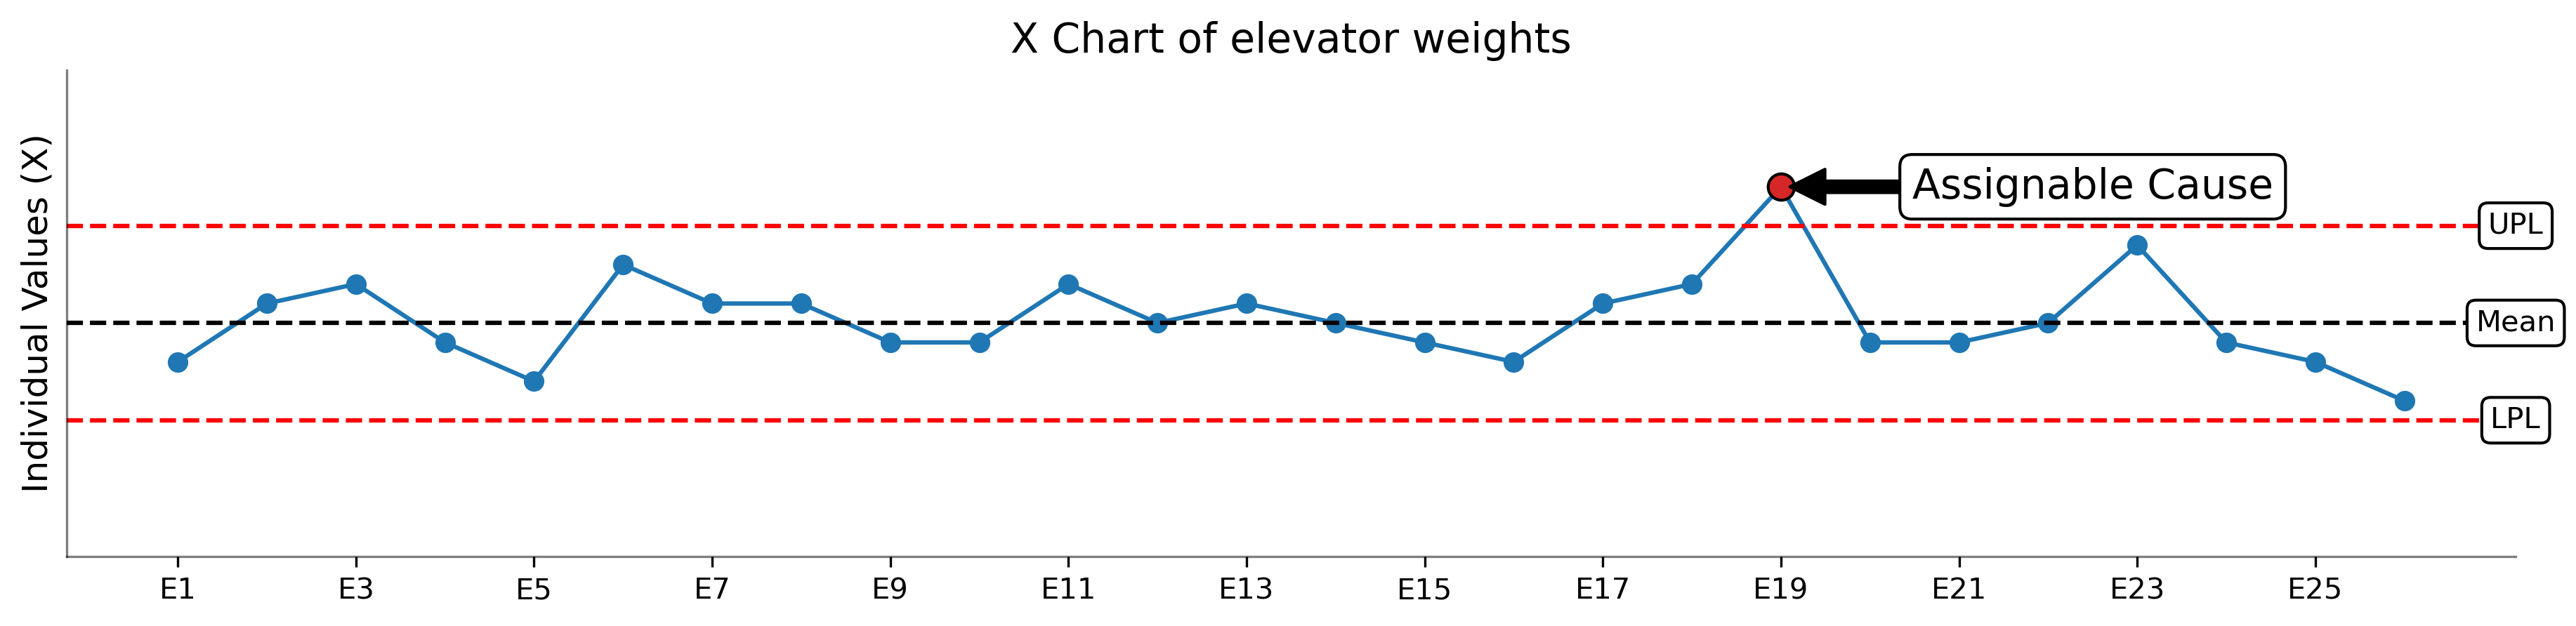

In [101]:
# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1] * 1.0, UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1] * 1.0, LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1] * 1.0, mean, 'Mean', color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    plt.axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
plt.ylabel("Individual Values (X)", fontsize=12)
plt.title("X Chart of elevator weights", fontsize=14)

# Fix the y-axis scale so its comparable to Figure 3
plt.ylim(680,705)

# Remove y tick labels
ax.set_yticks([])

# Add annotation for E19 assignable cause 
plt.annotate('Assignable Cause', 
             xy=(18.1,699),  # x, y coordinates of the annotation
             xytext=(21.5, 699),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black',
                      boxstyle='round'),
             arrowprops=dict(color='black'))

# Specify spine visibility 
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

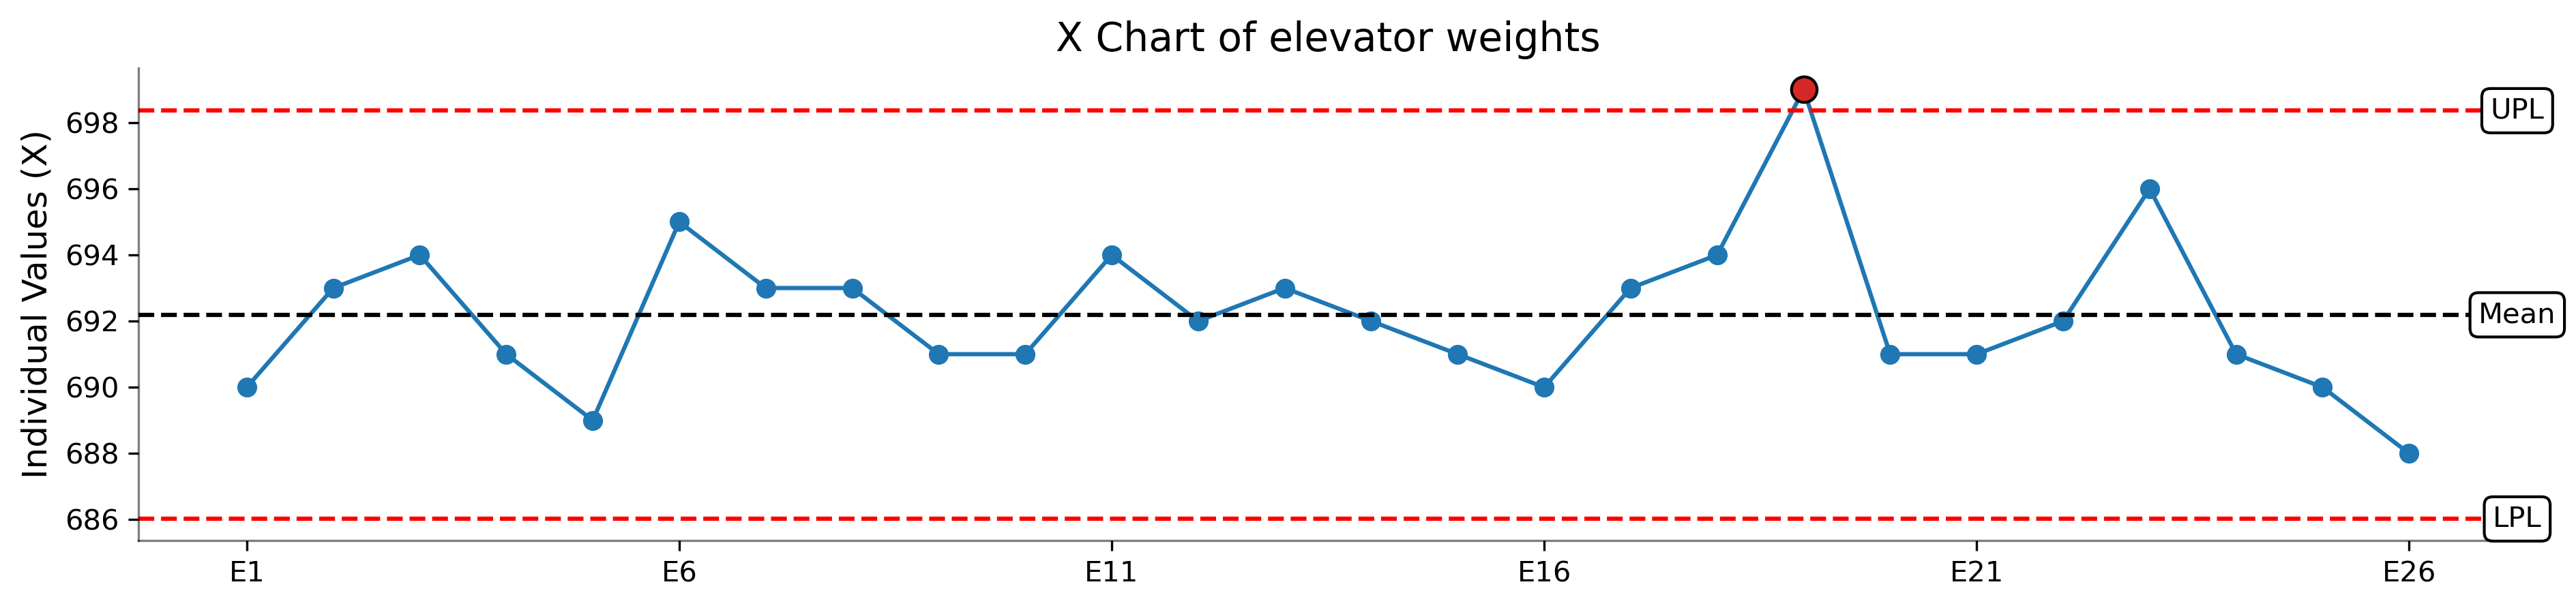

In [99]:
elevator_xchart_results = xmr.xchart(elevator_df, 'Weight (g)', 'PartNumber',
                                    show_limit_values=False, title='X Chart of elevator weights')

In [14]:
# Show results
elevator_xchart_results['XmR Chart Statistics']

,Chart,PBC Params,Param Values
0,X-Chart,Mean,692.19
1,X-Chart,UPL,698.36
2,X-Chart,LPL,686.02
3,X-Chart,PLR,12.34
4,mR-Chart,Ave. mR,2.32
5,mR-Chart,URL,7.58


## Fig 25.3: Limit chart of elevator weights

In [15]:
# Assign the spec limits 
elevator_USL = int(elevator_df.at[1,'USL'])
elevator_LSL = int(elevator_df.at[1,'LSL'])
elevator_target = int(elevator_df.at[1,'Target'])

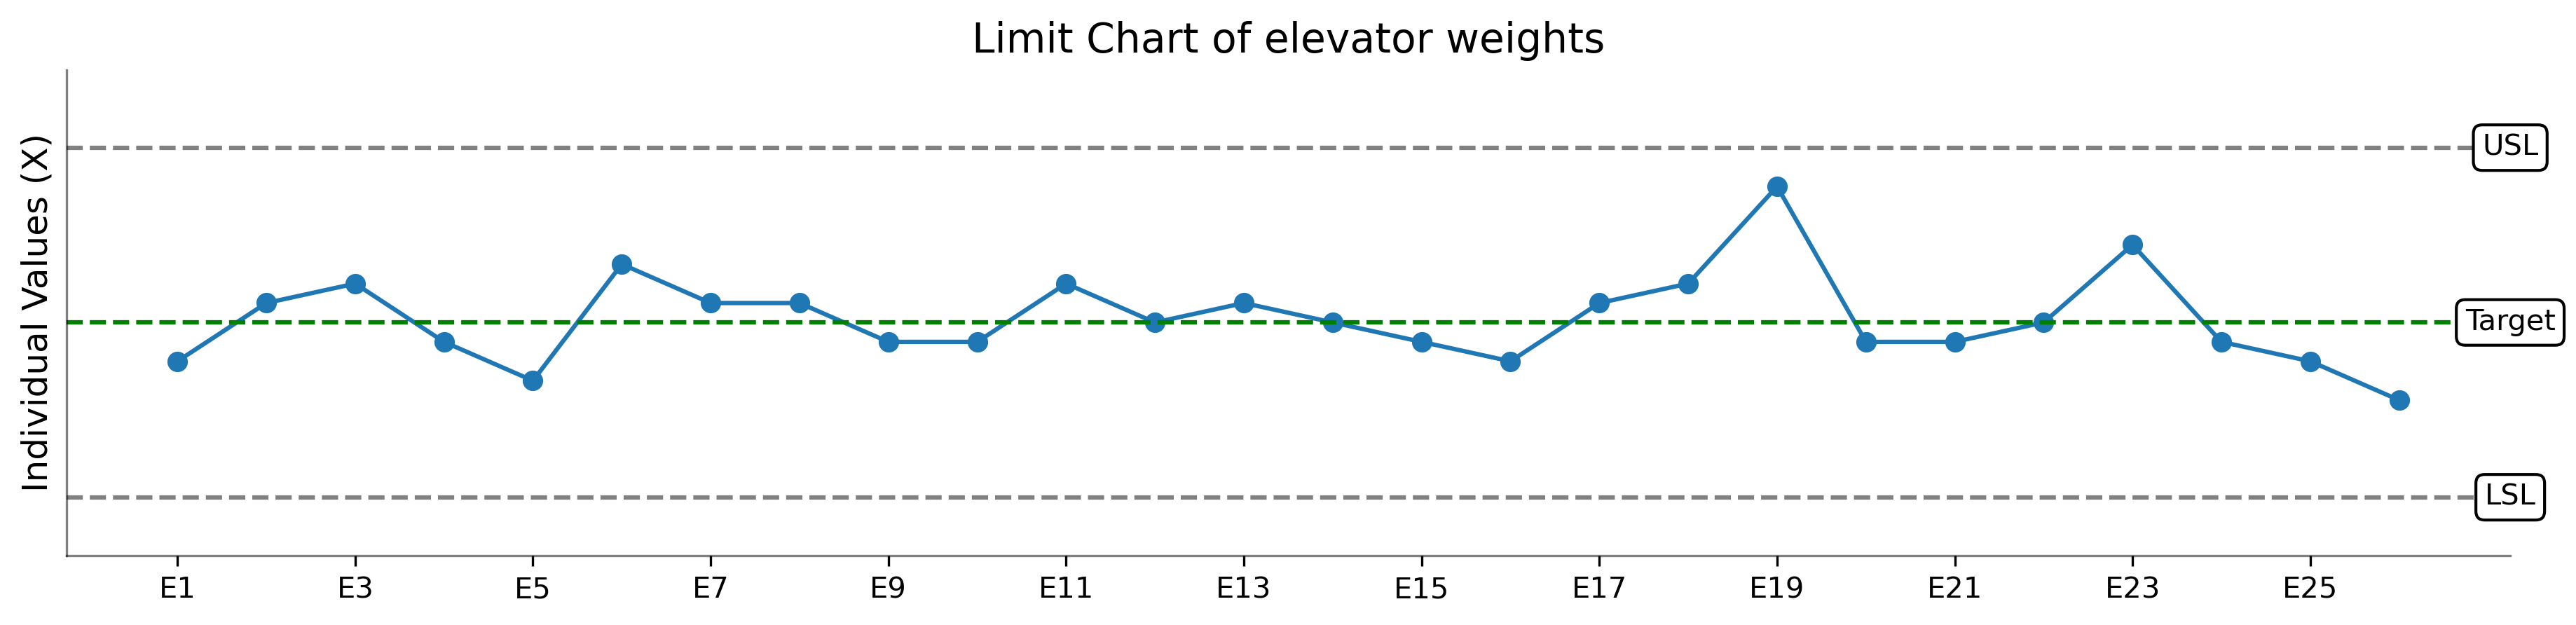

In [47]:
# Specify round_value
round_value = 0

# Specify tickinterval
tickinterval = 2

# Disaggregate the dataframe 
data = elevator_df["Weight (g)"]
labels = elevator_df["PartNumber"]

# Assign the spec limits 
USL = elevator_df.at[1,'USL']
LSL = elevator_df.at[1,'LSL']
target = elevator_df.at[1,'Target']

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
limit_chart_lines = [(target,'green'), (USL,'grey'), (LSL,'grey')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
limit_chart_labels = [(target,target),(UPL,UPL),(LPL,LPL)]

# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1] * 1.0, USL, 'USL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1] * 1.0, LSL, 'LSL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1] * 1.0, target,'Target', color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in limit_chart_lines:
    plt.axhline(value, ls='--', c=color)

# Remove upper and right spines 
sns.despine()

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
plt.ylabel("Individual Values (X)", fontsize=12)
plt.title("Limit Chart of elevator weights", fontsize=14)

ax.spines[['left','bottom']].set_alpha(0.5)

# Fix y axis range
plt.ylim(680,705)
# Remove yticks
ax.set_yticks([])

# Show plot
plt.show()

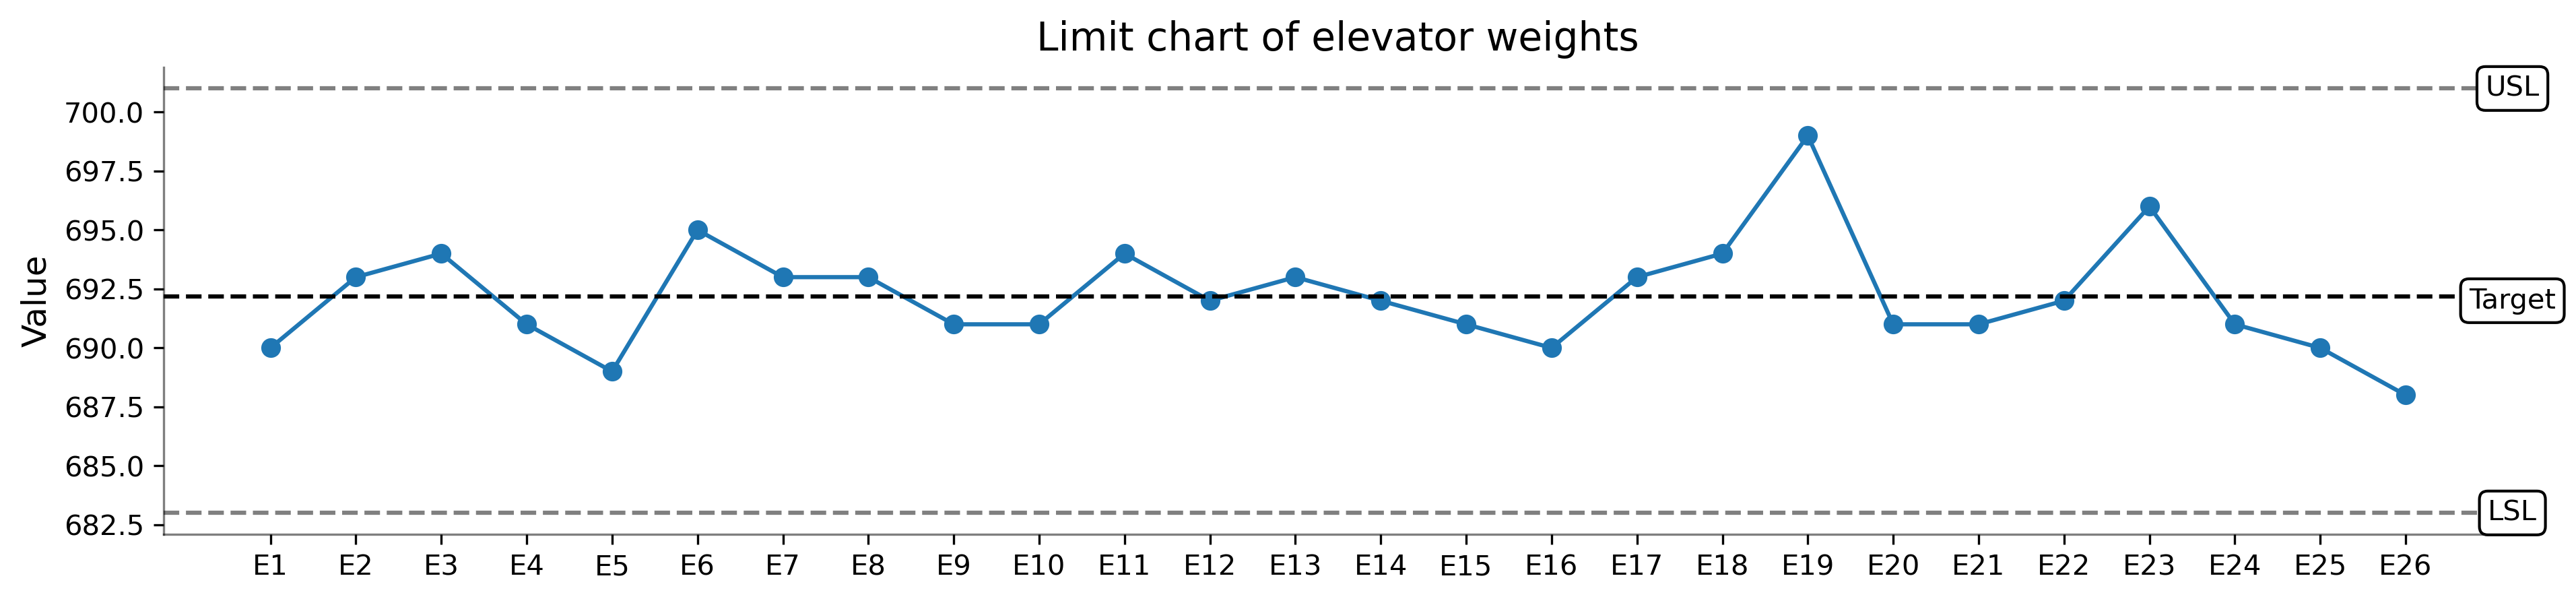

In [21]:
elevator_LC_results = lc.limit_chart(elevator_df, 
                                     'Weight (g)', 
                                     'PartNumber', 
                                     elevator_USL, 
                                     elevator_LSL, 
                                     elevator_target, 
                                     show_limit_values=False,
                                     title='Limit chart of elevator weights',
                                     tickinterval=1)

In [19]:
# Show limit chart results
elevator_LC_results

,Chart,Parameters,Values
0,Limit Chart,Mean,692.1923
1,Limit Chart,Target,692.0000
2,Limit Chart,Mean to Tar. Delta,-0.1923
3,Limit Chart,USL,701.0000
4,Limit Chart,LSL,683.0000
5,Limit Chart,Spec Limit Range,18.0000
6,Limit Chart,# of Values,26.0000
7,Limit Chart,# Outside Spec,0.0000
8,Limit Chart,% Outside Spec,0.0000


## Fig 25.4: Limit chart of aileron weights

In [49]:
# Assign the spec limits 
USL = int(aileron_df.at[1,'USL'])
LSL = int(aileron_df.at[1,'LSL'])
target = int(aileron_df.at[1,'Target'])

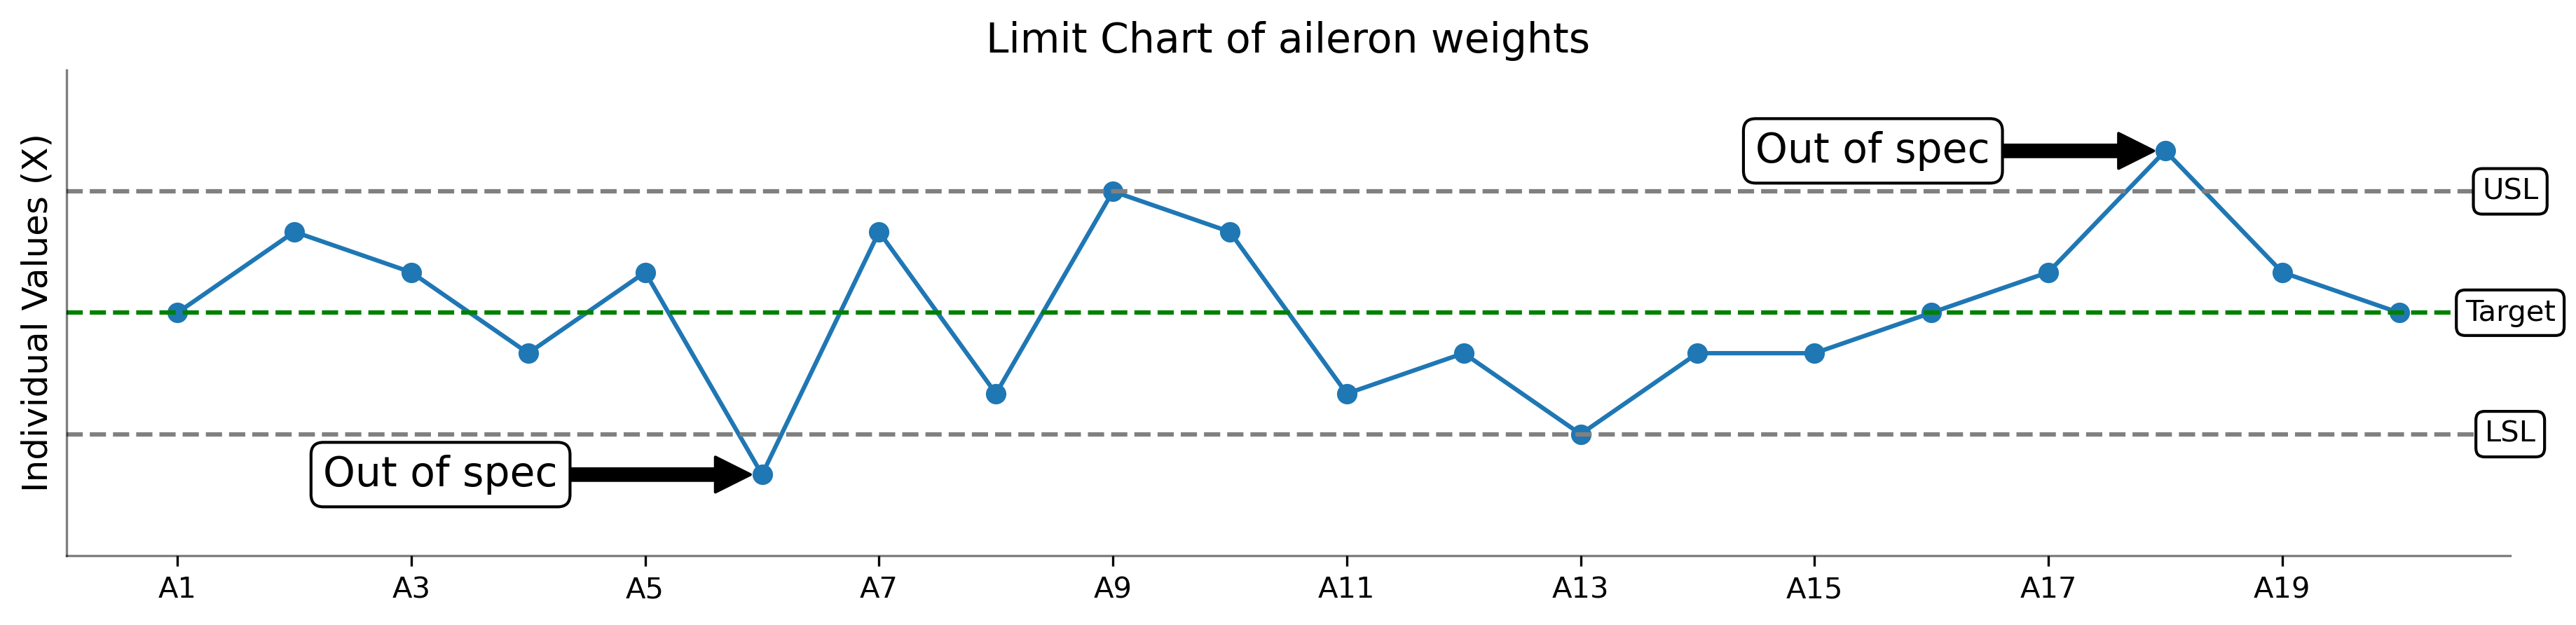

In [51]:
# Specify round_value
round_value = 0

# Specify tickinterval
tickinterval = 2

# Disaggregate the dataframe 
data = aileron_df["Weight (g)"]
labels = aileron_df["PartNumber"]

# Assign the spec limits 
USL = aileron_df.at[1,'USL']
LSL = aileron_df.at[1,'LSL']
target = aileron_df.at[1,'Target']

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
limit_chart_lines = [(target,'green'), (USL,'grey'), (LSL,'grey')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
limit_chart_labels = [(target,target),(UPL,UPL),(LPL,LPL)]

# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
bbox_props_centerlines = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1], USL, 'USL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], LSL, 'LSL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], target,'Target', color='black', ha='center', va='center', bbox=bbox_props_centerlines)

# Add centerline and process limits 
for value, color in limit_chart_lines:
    plt.axhline(value, ls='--', c=color)

# Remove upper and right spines 
sns.despine()

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
plt.ylabel("Individual Values (X)", fontsize=12)
plt.title("Limit Chart of aileron weights", fontsize=14)

# Fix y axis range
plt.ylim(861,873)
# Remove y ticks
ax.set_yticks([])

# Add annotation for A6
plt.annotate('Out of spec', 
             xy=(4.9,863),  # x, y coordinates of the annotation
             xytext=(2.25, 863),  # Position of the text
             fontsize=14,
             color='black',
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', edgecolor='black', 
                      boxstyle='round'),
             arrowprops=dict(color='black'))

# Add annotation for A18
plt.annotate('Out of spec', 
             xy=(16.9,871),  # x, y coordinates of the annotation
             xytext=(14.5, 871),  # Position of the text
             fontsize=14,
             color='black',
             ha='center',
             verticalalignment='center',
             bbox=dict(facecolor='white', edgecolor='black', 
                      boxstyle='round'),
             arrowprops=dict(color='black'))

ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

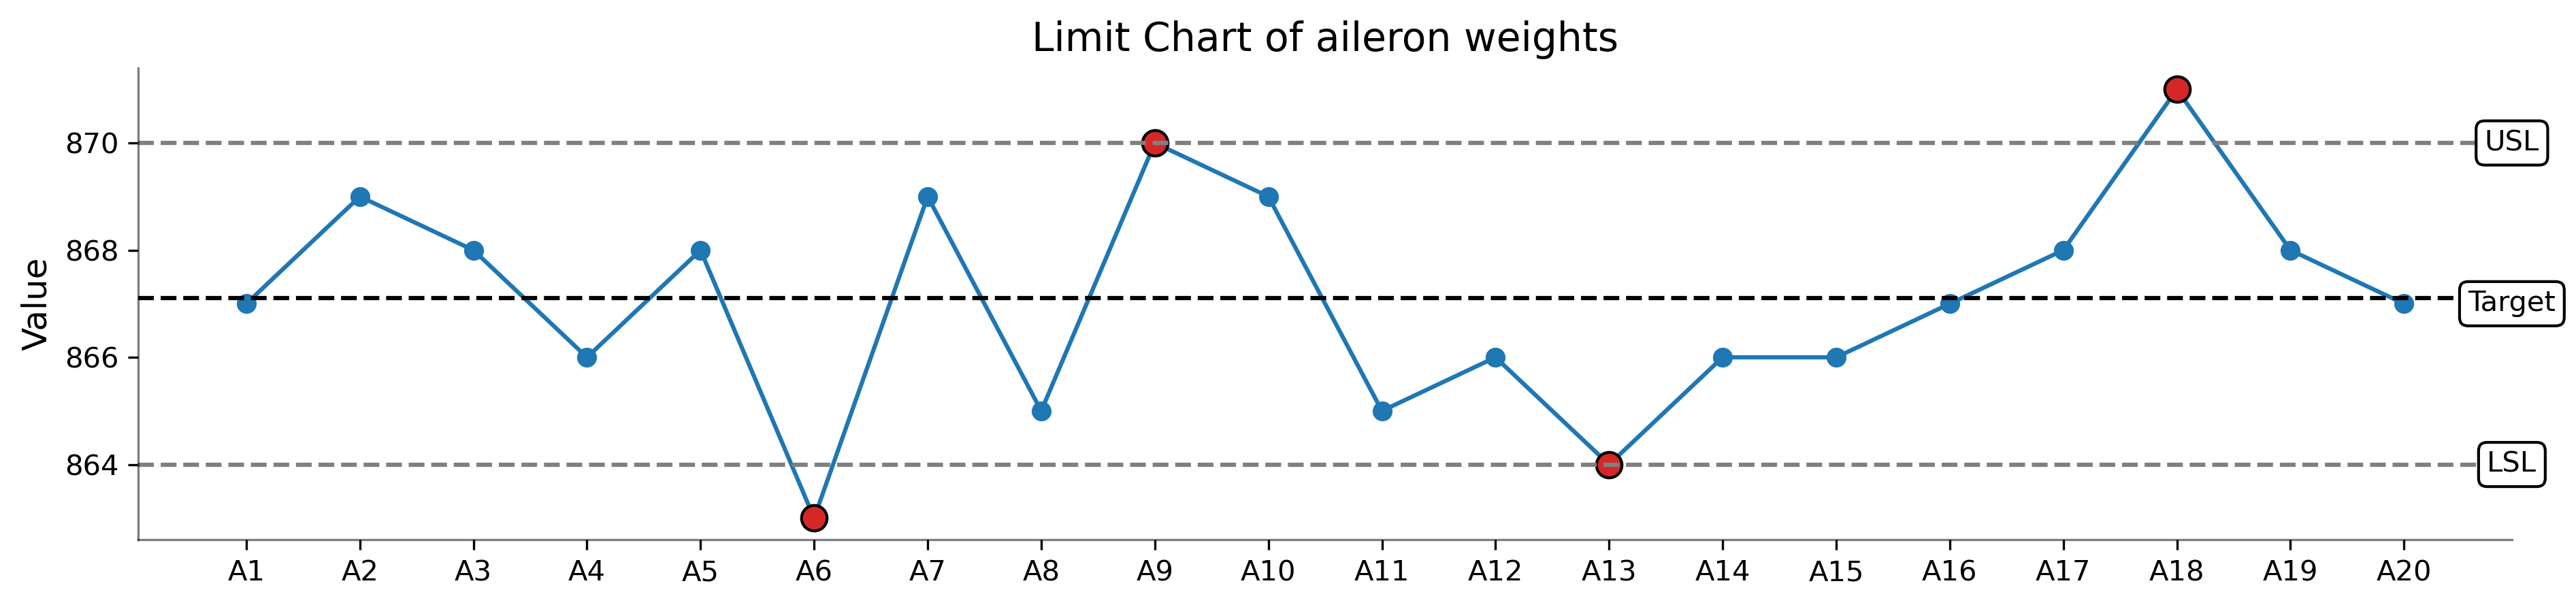

In [50]:
aileron_LC_results = lc.limit_chart(aileron_df, 
                                    'Weight (g)', 
                                    'PartNumber', 
                                    USL, LSL, target, 
                                    show_limit_values=False, 
                                    tickinterval=1, 
                                    title='Limit Chart of aileron weights')

## Fig 25.5: XmR Chart of aileron weights

In [88]:
# Specify round_value
round_value = 0

# Specify tickinterval
tickinterval = 2

# Disaggregate the dataframe 
data = aileron_df["Weight (g)"]
moving_ranges = round(abs(data.diff()),round_value)
labels = aileron_df["PartNumber"]

# Add moving ranges to df as column
aileron_df = aileron_df.copy()
aileron_df['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
AmR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*AmR),round_value)
LPL = round(mean - (C1*AmR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*AmR,round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
mrchart_lines = [(AmR,'black'), (URL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(AmR,AmR)]

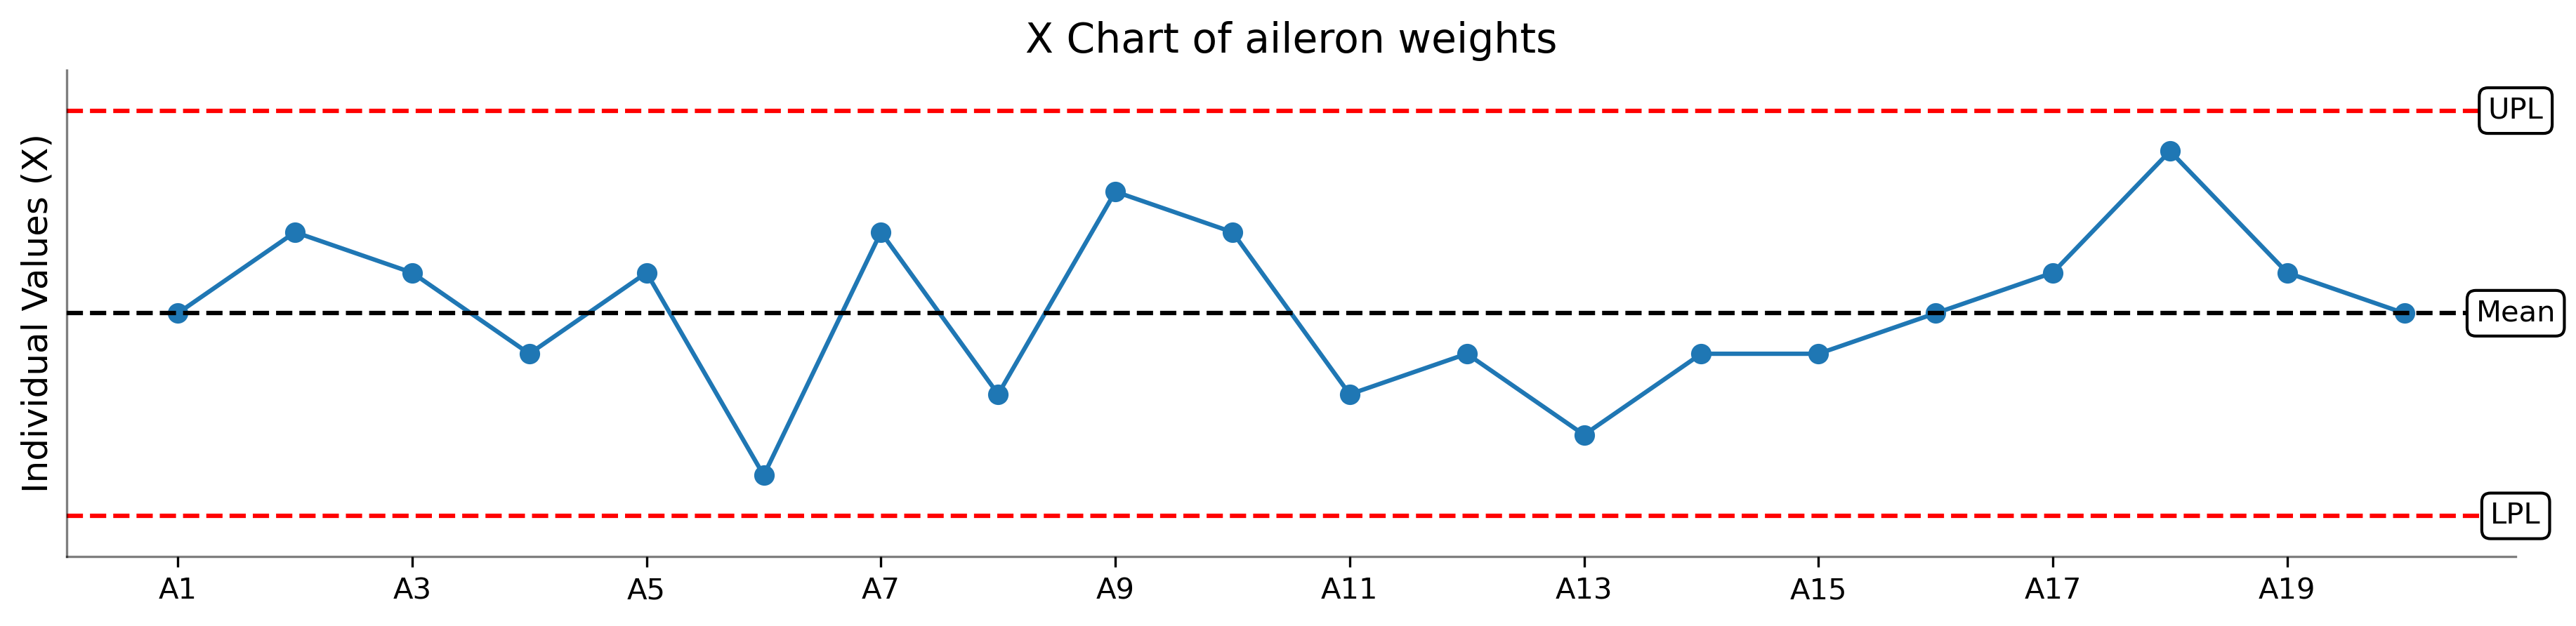

In [89]:
# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1] * 1.0, UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1] * 1.0, LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1] * 1.0, mean, 'Mean', color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    plt.axhline(value, ls='--', c=color)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
ax.set_xlabel("",fontsize=12)
ax.set_ylabel("Individual Values (X)", fontsize=12)
ax.set_title("X Chart of aileron weights", fontsize=14)

# # Fix y axis range
plt.ylim(861,873)
# Remove y-axis ticks
ax.set_yticks([])

# Specify spine visibility 
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

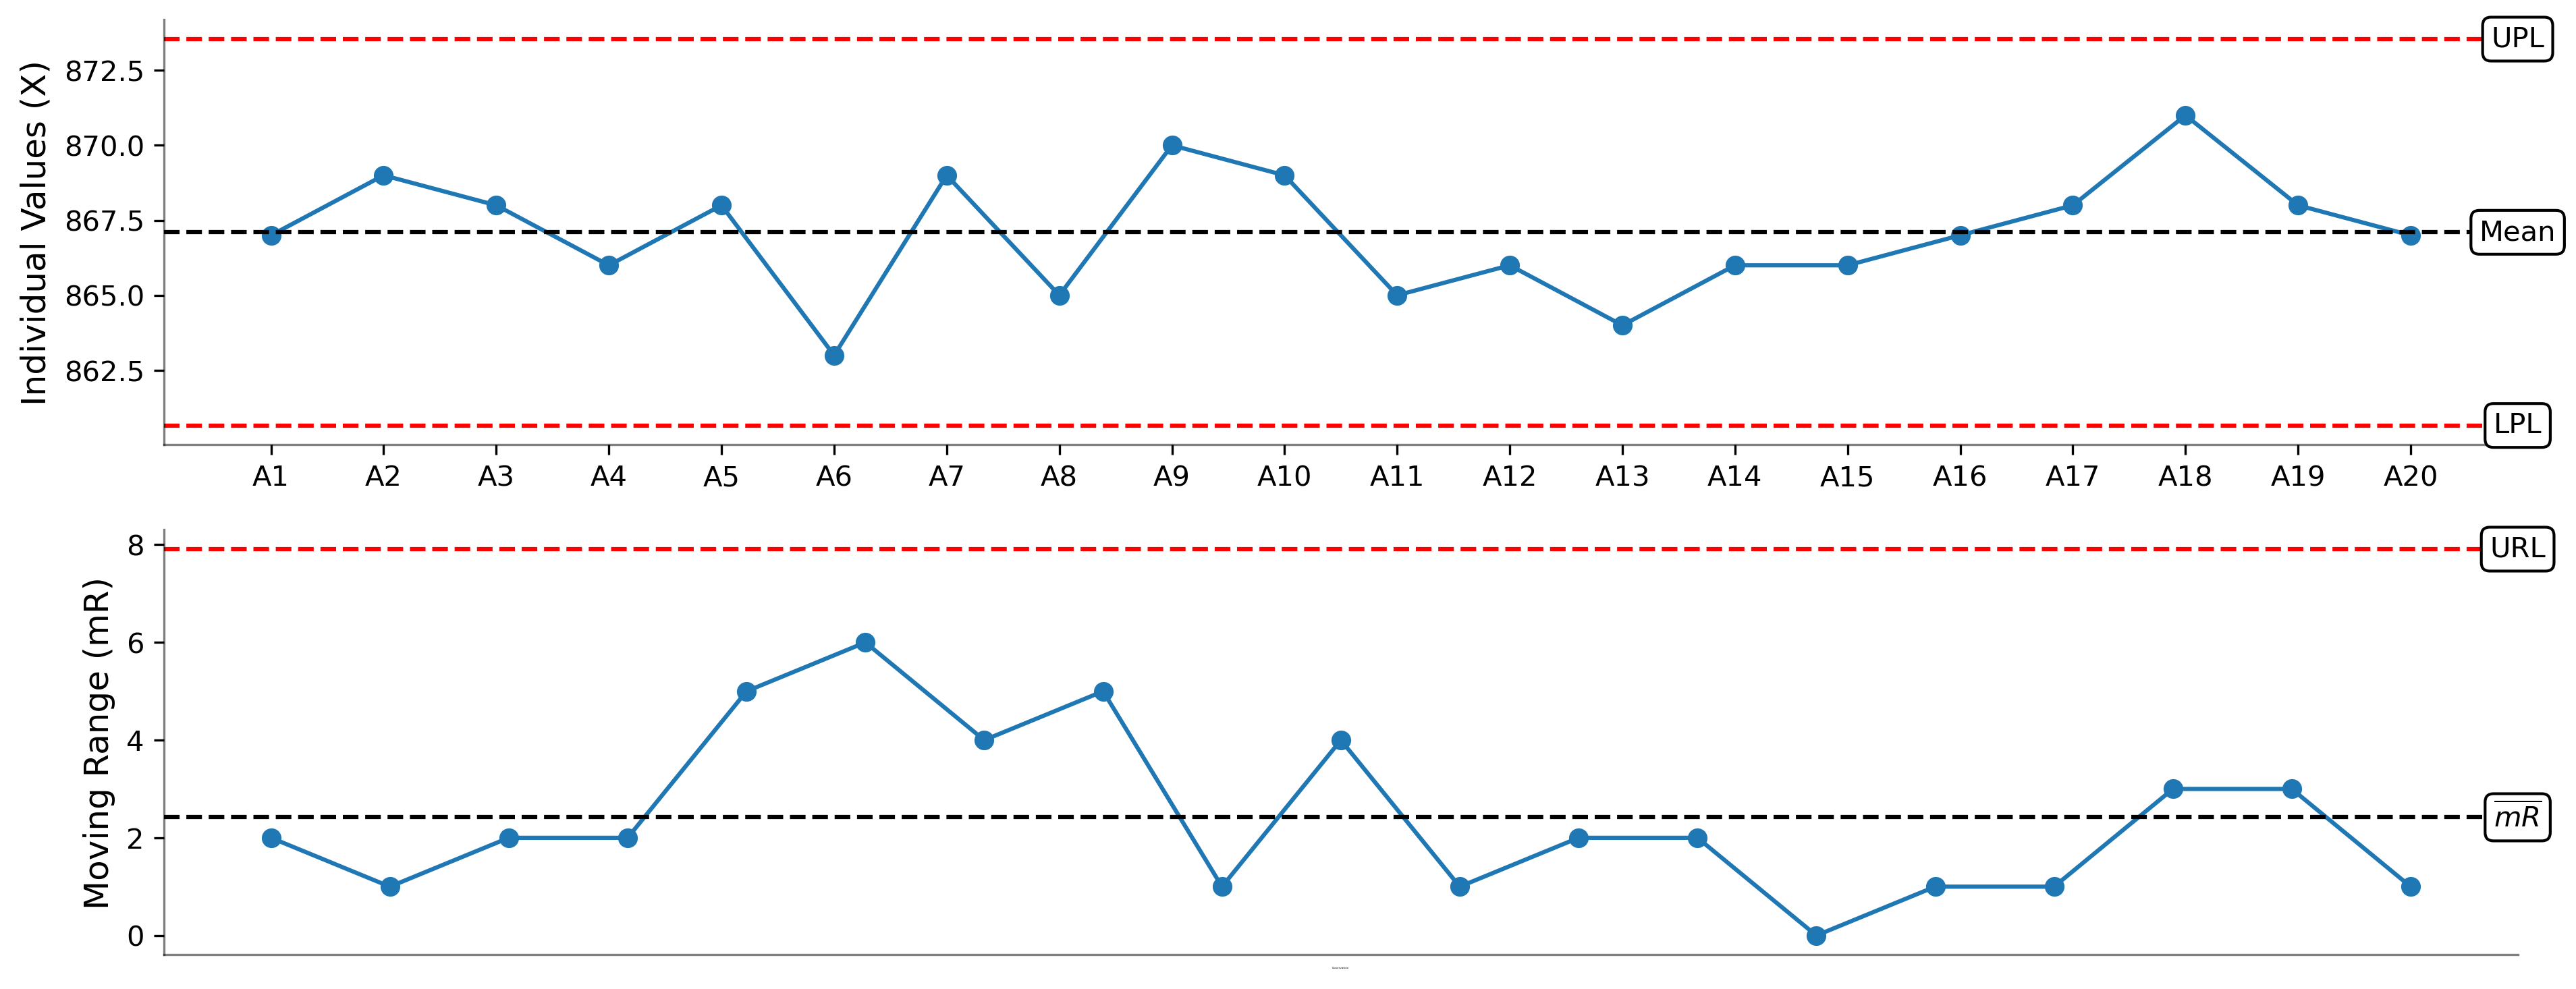

In [87]:
aileron_xmr_results = xmr.xmrchart(aileron_df, 
                                   'Weight (g)', 
                                   'PartNumber', 
                                   show_limit_values=False,
                                   tickinterval=1)

## Fig 25.6: X Chart of part lengths with spec limits

In [81]:
# Specify round_value
round_value = 5

# Specify tickinterval
tickinterval = 10

# Disaggregate the dataframe 
data = part_lengths_df["x_actual"]
moving_ranges = round(abs(data.diff()),round_value)
labels = part_lengths_df["part_number"]

# Add moving ranges to df as column
part_lengths_df = part_lengths_df.copy()
part_lengths_df['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
AmR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*AmR),round_value)
LPL = round(mean - (C1*AmR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*AmR,round_value)

# Specify USL and LSL
USL = 219.3
LSL = 218.7

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
mrchart_lines = [(AmR,'black'), (URL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(AmR,AmR)]

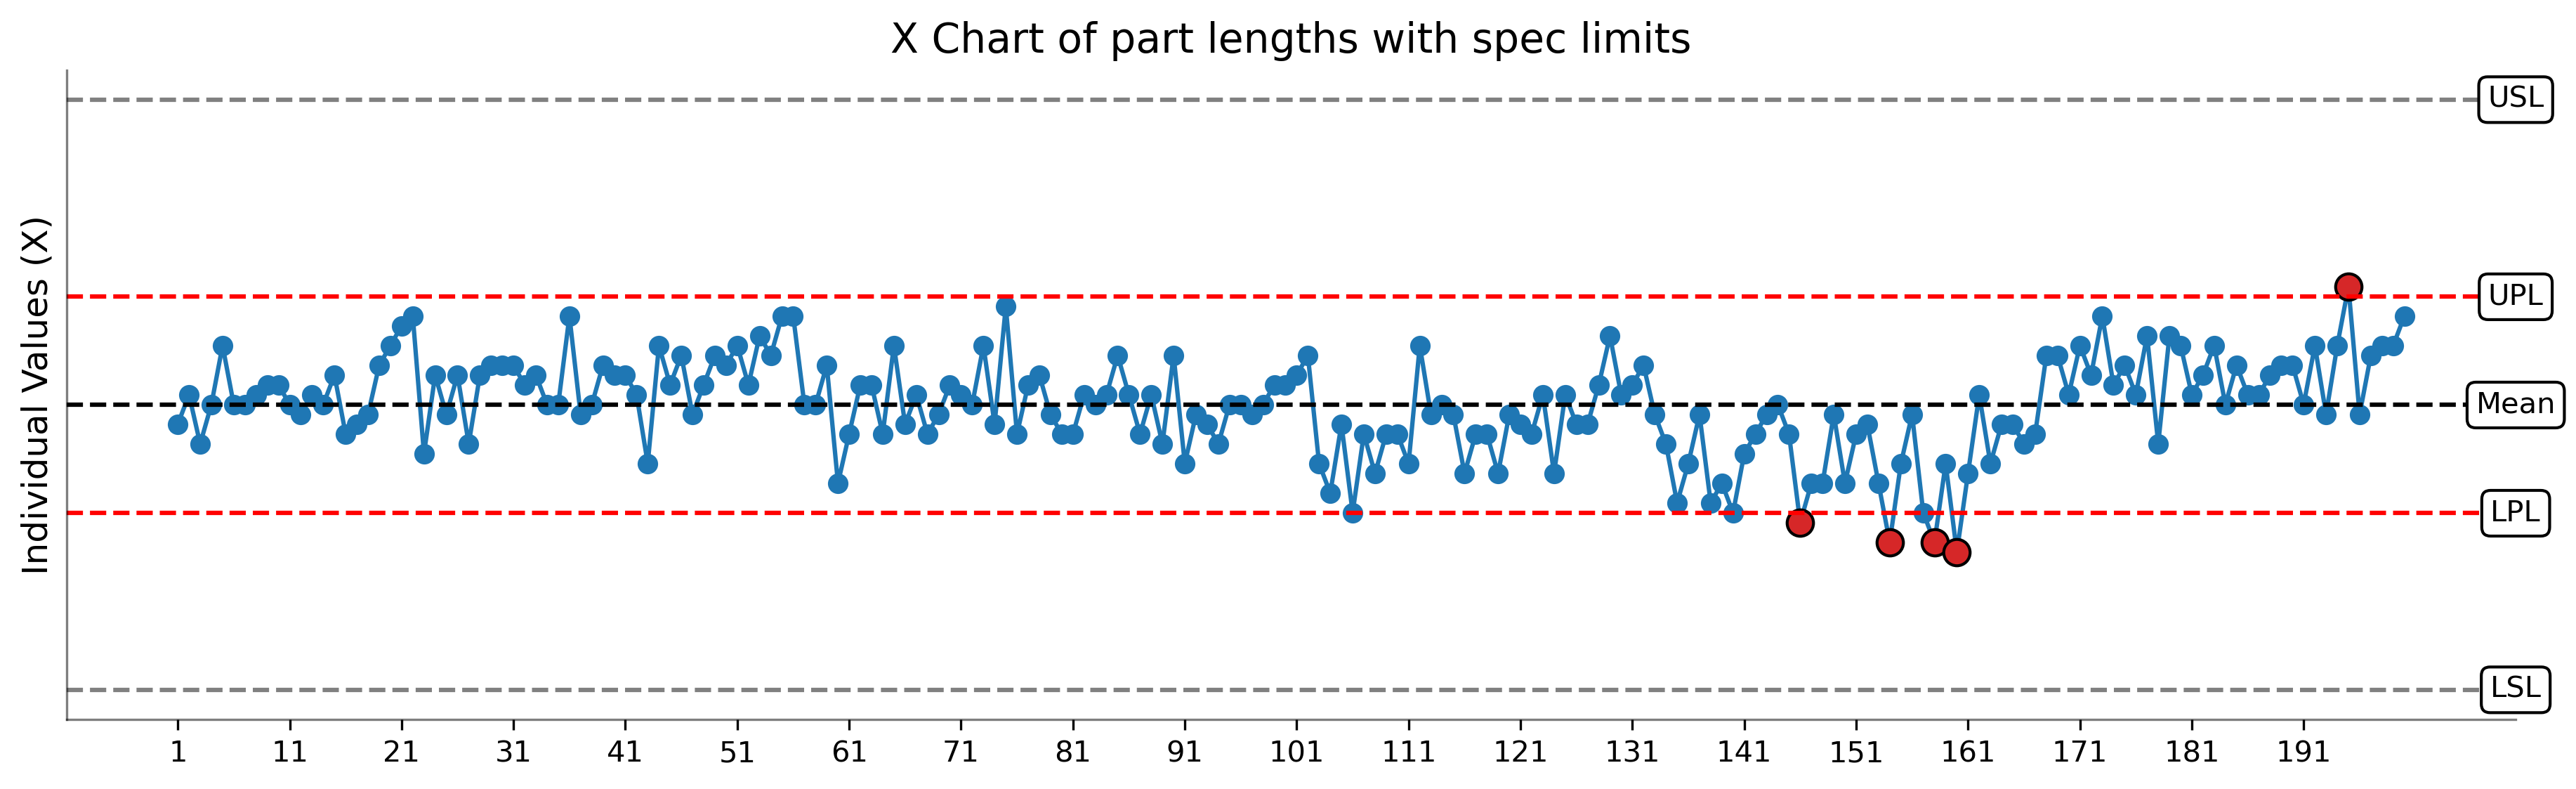

In [82]:
# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,4), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

ax.axhline(USL, c='gray', ls='--')
ax.axhline(LSL, c='gray', ls='--')

# Add masking parameters to color values outside process limits
ax.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], mean, 'Mean', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], USL, 'USL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], LSL, 'LSL', color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    plt.axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
plt.ylabel("Individual Values (X)", fontsize=12)
plt.title("X Chart of part lengths with spec limits", fontsize=14)

# Remove y tick labels
ax.set_yticks([])

# Specify spine visibility 
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Fig 25.7: X Chart of part lengths

In [83]:
# Specify round_value
round_value = 5

# Specify tickinterval
tickinterval = 10

# Disaggregate the dataframe 
data = part_lengths_df["x_actual"]
moving_ranges = round(abs(data.diff()),round_value)
labels = part_lengths_df["part_number"]

# Add moving ranges to df as column
part_lengths_df = part_lengths_df.copy()
part_lengths_df['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
AmR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*AmR),round_value)
LPL = round(mean - (C1*AmR),round_value)
# Calculate process limit range (PLR)
PLR = UPL - LPL
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)
# Calculate the Upper Range Limit
URL = round(C2*AmR,round_value)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
mrchart_lines = [(AmR,'black'), (URL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(AmR,AmR)]

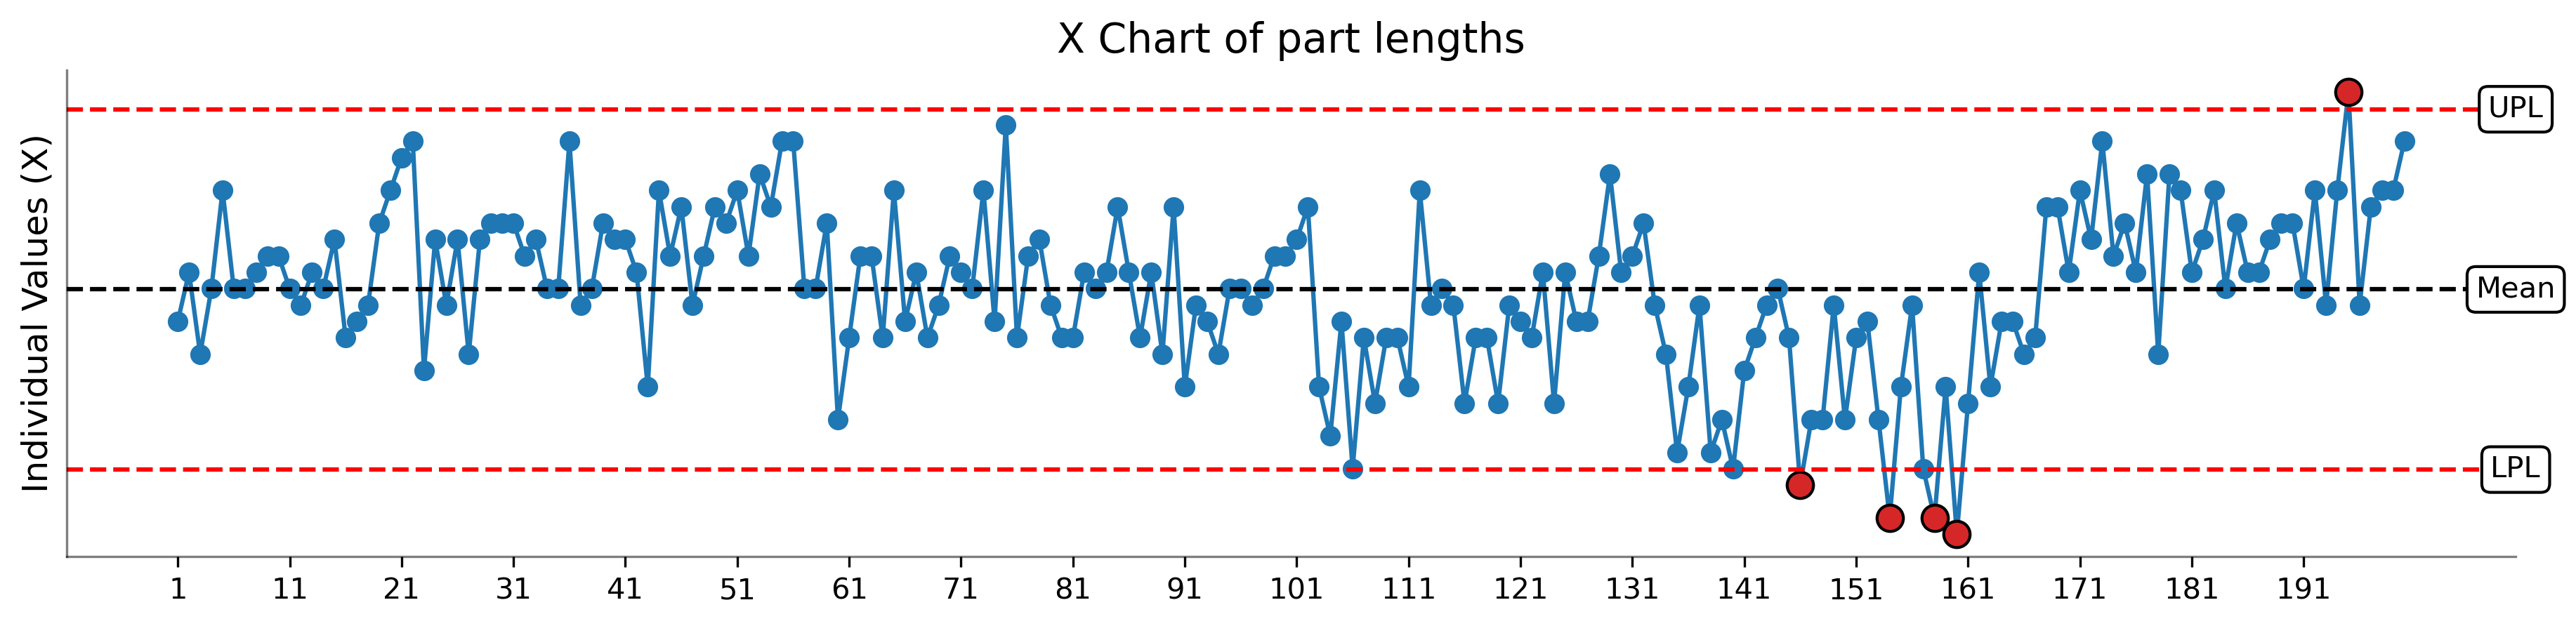

In [84]:
# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
ax.text(ax.get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], mean, 'Mean', color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    plt.axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
plt.ylabel("Individual Values (X)", fontsize=12)
plt.title("X Chart of part lengths", fontsize=14)

# Remove y tick labels
ax.set_yticks([])

# Specify spine visibility 
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

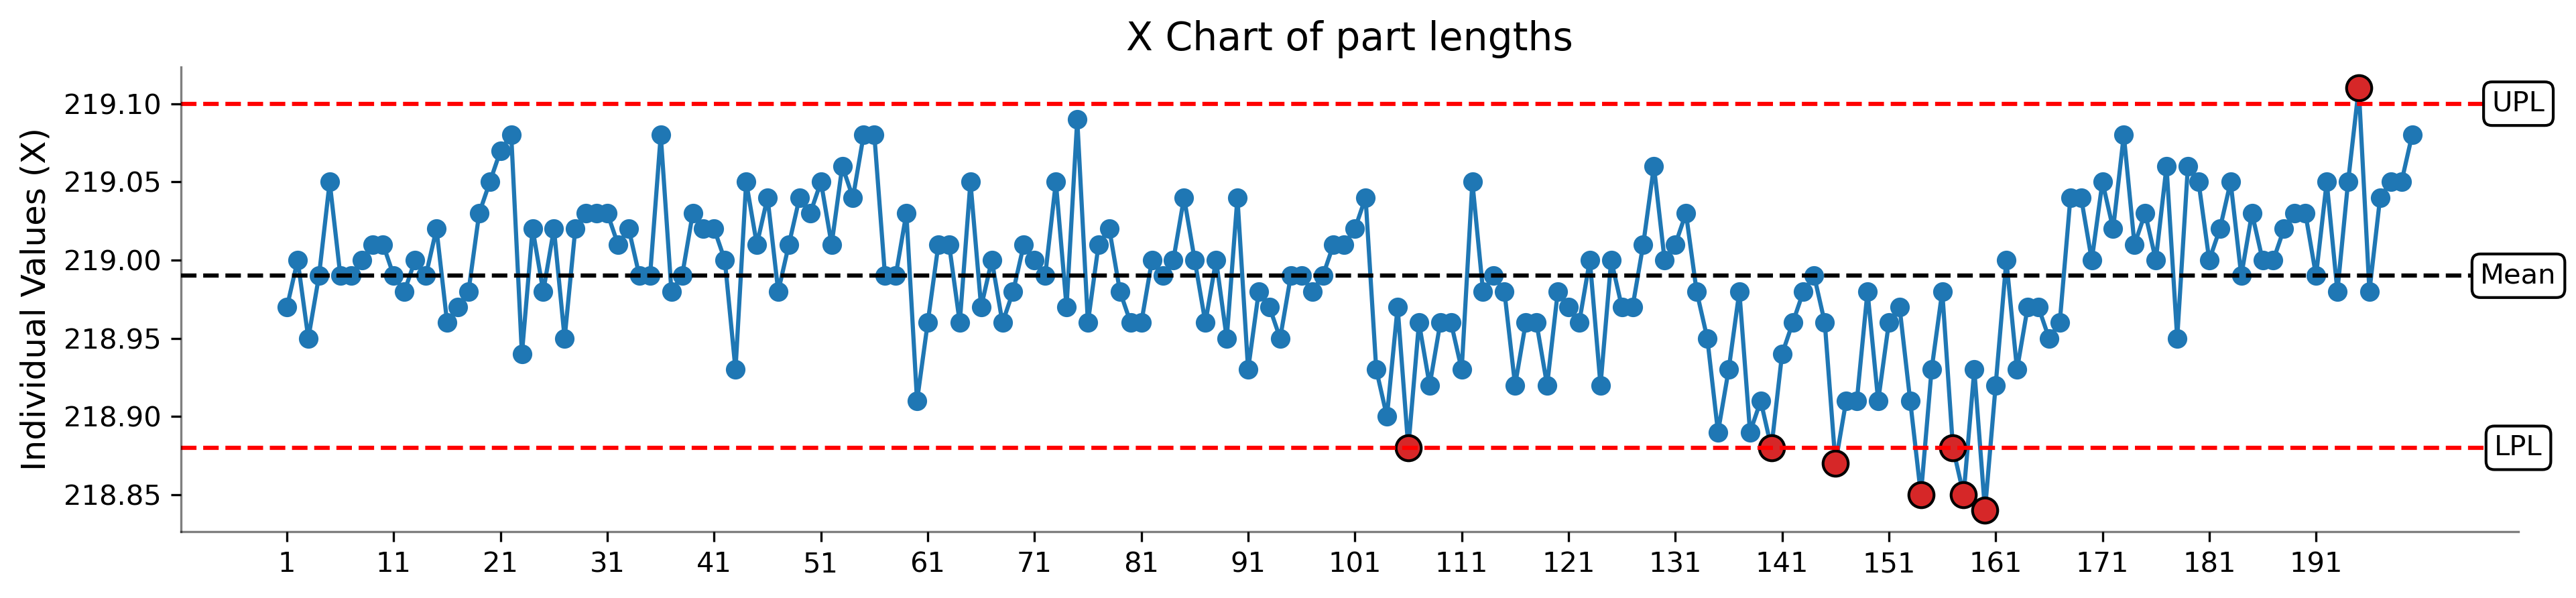

In [75]:
# Generate same plot using process_improvement library
part_length_xmr_results = xmr.xchart(part_lengths_df, 
                                     'x_actual', 
                                     'part_number', 
                                     tickinterval=10, 
                                     show_limit_values=False, 
                                     title='X Chart of part lengths')

## Fig 25.8: Capability histogram of part lengths

In [33]:
length_LSL = 218.7
length_USL = 219.3
tolerance = length_USL - length_LSL
target = length_LSL + (tolerance/2)

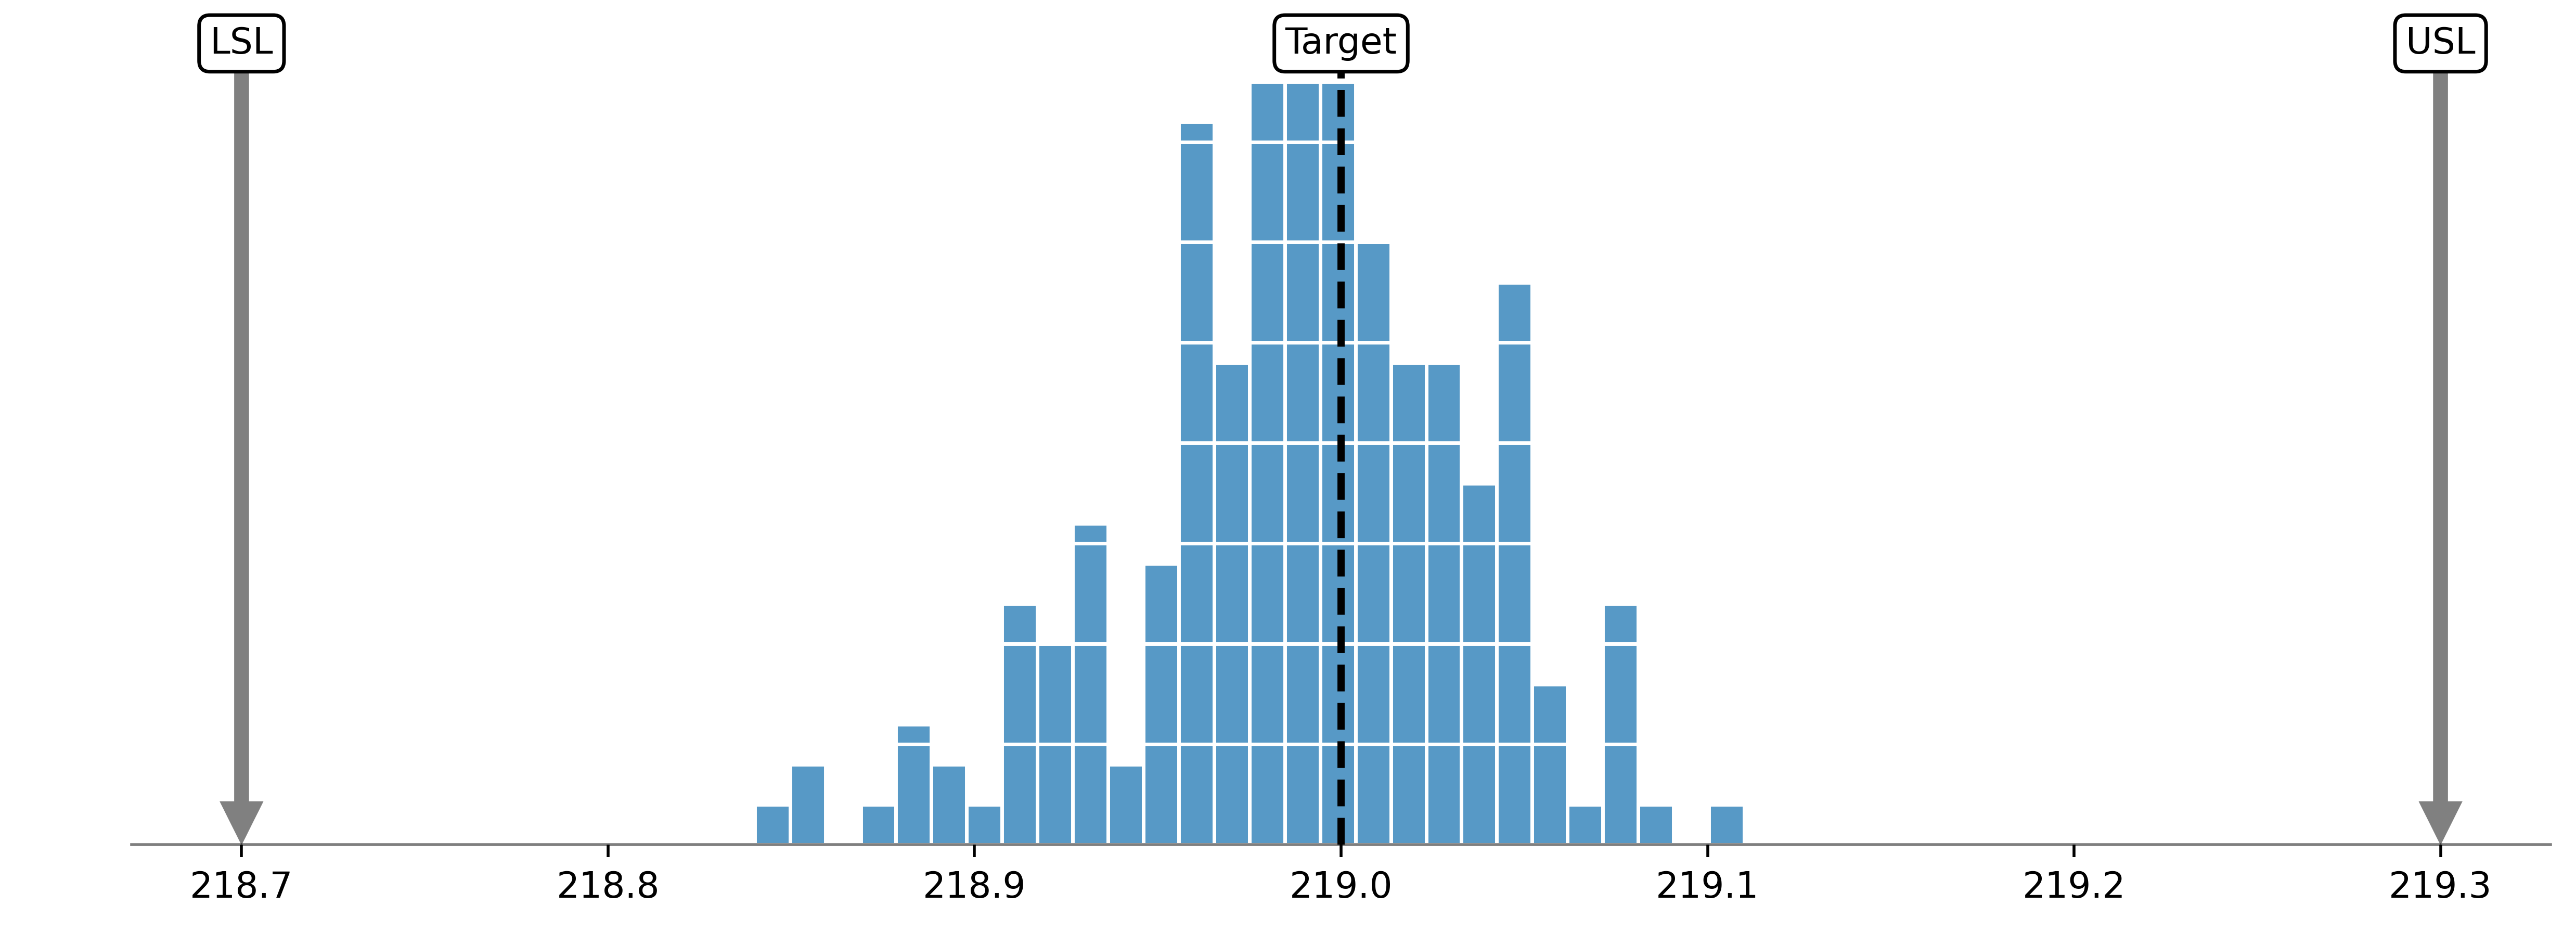

In [36]:
part_lengths_CH_results = pc.capability_histogram(part_lengths_df['x_actual'],
                                                 length_USL, length_LSL, target,
                                                 mean_label=False, 
                                                 show_capabilities=False, bins=28)

## Fig 25.9: Limit chart of part lengths

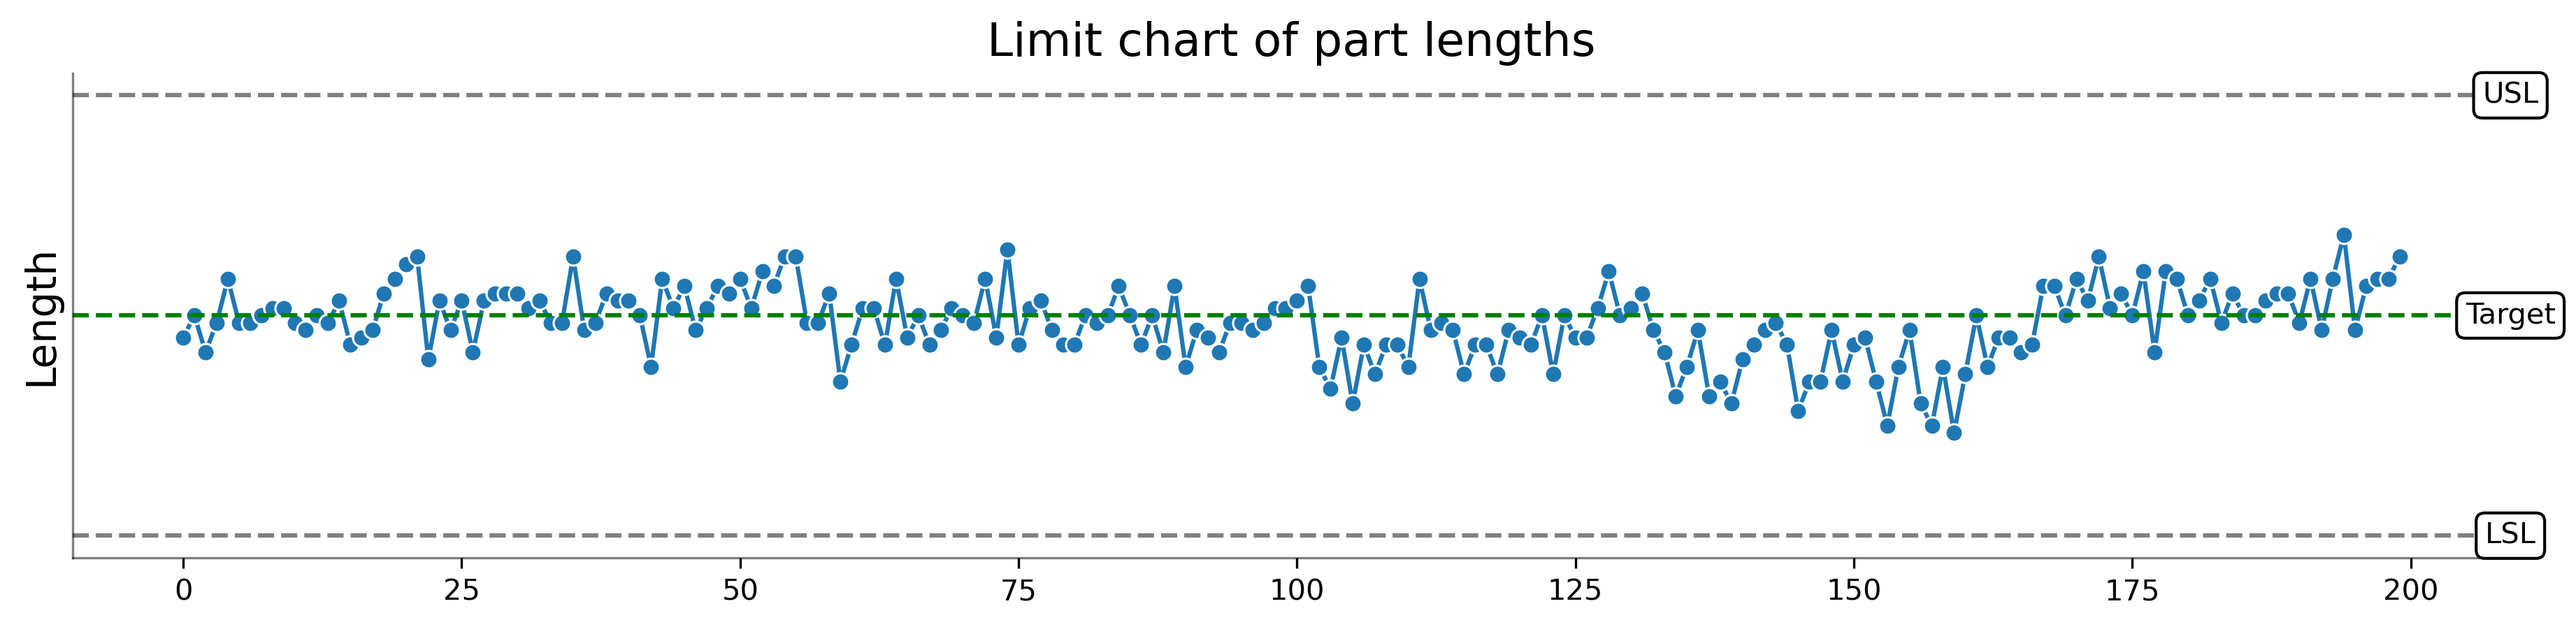

In [66]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.lineplot(part_lengths_df['x_actual'], marker='o')

ax.axhline(219, ls='--', c='green')
ax.axhline(219.3, ls='--', c='gray')
ax.axhline(218.7, ls='--', c='gray')

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

ax.text(ax.get_xlim()[1], 219.3, 'USL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], 218.7, 'LSL', color='black', ha='center', va='center', bbox=bbox_props)
ax.text(ax.get_xlim()[1], 219, 'Target', color='black', ha='center', va='center', bbox=bbox_props)

sns.despine()
ax.spines[['left','bottom']].set_alpha(0.95)

ax.set_yticks([])
ax.set_ylabel('Length', fontsize=14)
plt.title('Limit chart of part lengths', fontsize=16)

# Show plot
plt.show()

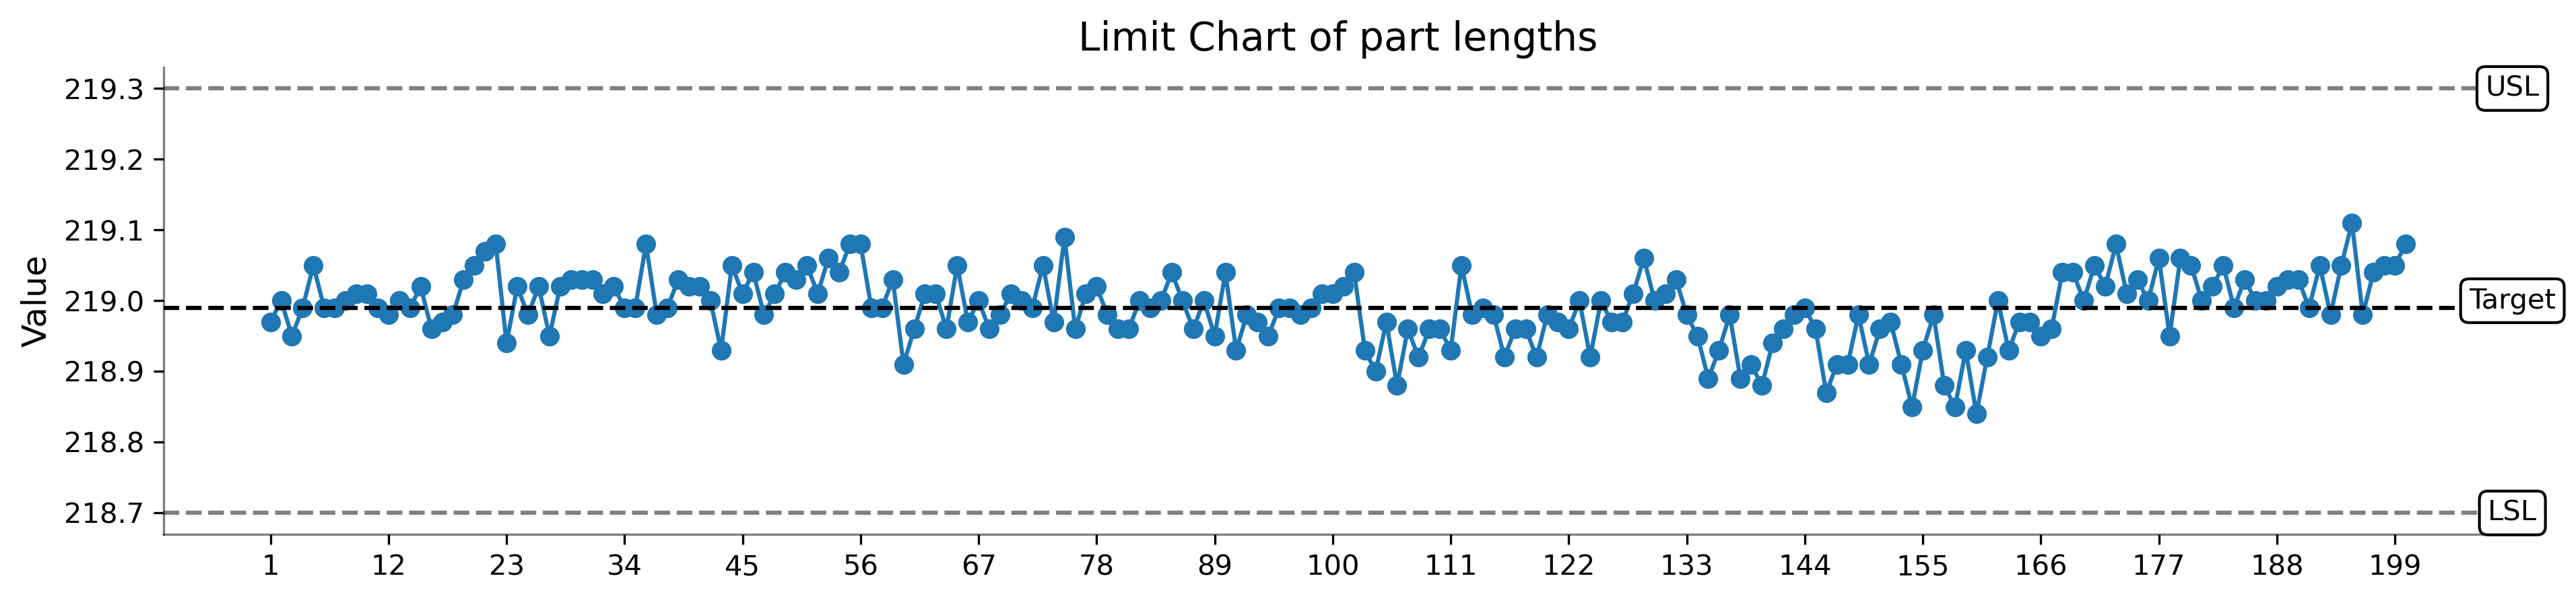

In [39]:
part_length_LC_results = lc.limit_chart(part_lengths_df, 
                                        'x_actual', 
                                        'part_number', 
                                        length_USL, length_LSL, target,
                                        show_limit_values=False,
                                        tickinterval=11, 
                                        title='Limit Chart of part lengths')

## Fig 25.10: Multi chart of elevator weights

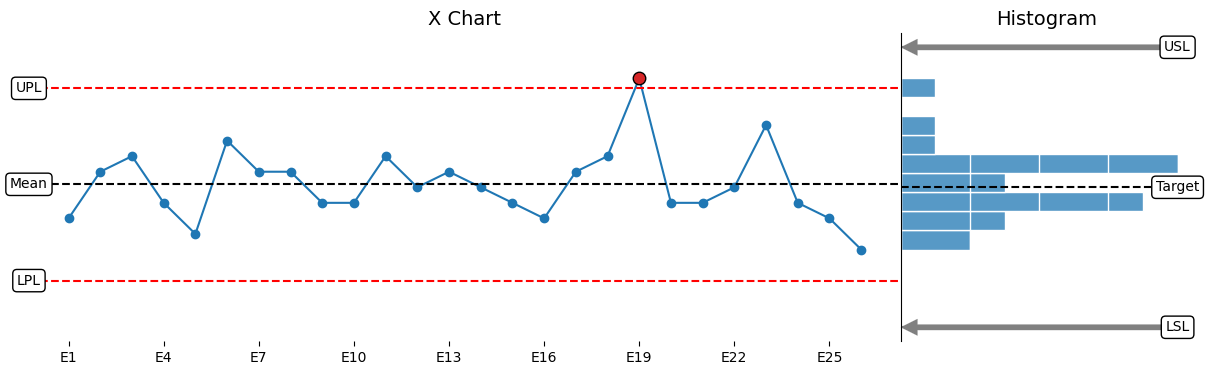

In [67]:
elevator_MC_results = pc.multi_chart(elevator_df, 'Weight (g)', 'PartNumber', elevator_USL, elevator_LSL,
                                     elevator_target, tick_interval=3)

## Fig 25.11: Elevtor weights two ways

In [ ]:
# Set the tickinterval
tickinterval=3

# Disaggregate the dataframe 
data = elevator_df["Weight (g)"]
moving_ranges = round(abs(data.diff()),round_value)
labels = elevator_df["PartNumber"]

# Add moving ranges to df as column
elevator_df = elevator_df.copy()
elevator_df['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
AmR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*AmR),round_value)
LPL = round(mean - (C1*AmR),round_value)
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)

# Assign the spec limits 
USL = elevator_df.at[1,'USL']
LSL = elevator_df.at[1,'LSL']
target = elevator_df.at[1,'Target']

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
limit_chart_lines = [(target,'green'), (USL,'grey'), (LSL,'grey')]

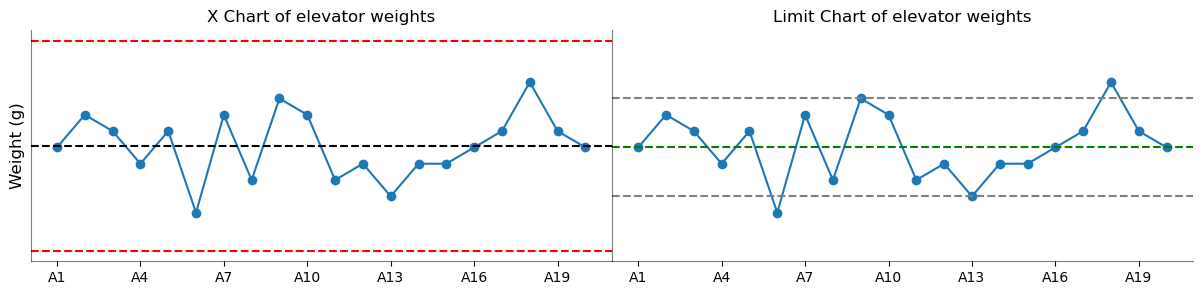

In [74]:
# Generate fig, ax
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,3), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0)

# Plot process behavior chart to ax[0]
ax[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add centerline and process limits 
for value, color in xchart_lines:
    ax[0].axhline(value, ls='--', c=color)
    
#Plot limit plot to ax[1]
ax[1].plot(labels, data, marker='o')

# Add centerline and process limits 
for value, color in limit_chart_lines:
    ax[1].axhline(value, ls='--', c=color)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

ax[0].set_title('X Chart of elevator weights')
ax[1].set_title('Limit Chart of elevator weights')

ax[0].set_yticks([])

# Specify axis labels and title
# plt.xlabel("",fontsize=12)
ax[0].set_ylabel("Weight (g)", fontsize=12)
# plt.title("Process behavior chart of elevator weights", fontsize=14)

# Specify spine visibility 
sns.despine()
for value in range(0,2):
    ax[value].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Fig 25.12: Aileron weights two ways

In [72]:
# Set the tickinterval
tickinterval=3

# Disaggregate the dataframe 
data = aileron_df["Weight (g)"]
moving_ranges = round(abs(data.diff()),round_value)
labels = aileron_df["PartNumber"]

# Add moving ranges to df as column
aileron_df = aileron_df.copy()
aileron_df['Moving Ranges'] = pd.Series(moving_ranges)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
AmR = round(moving_ranges.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*AmR),round_value)
LPL = round(mean - (C1*AmR),round_value)
# Conditionally determine LPL if LPL is less than zero
LPL = max(LPL,0)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)

# Assign the spec limits 
USL = aileron_df.at[1,'USL']
LSL = aileron_df.at[1,'LSL']
target = aileron_df.at[1,'Target']

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
limit_chart_lines = [(target,'green'), (USL,'grey'), (LSL,'grey')]

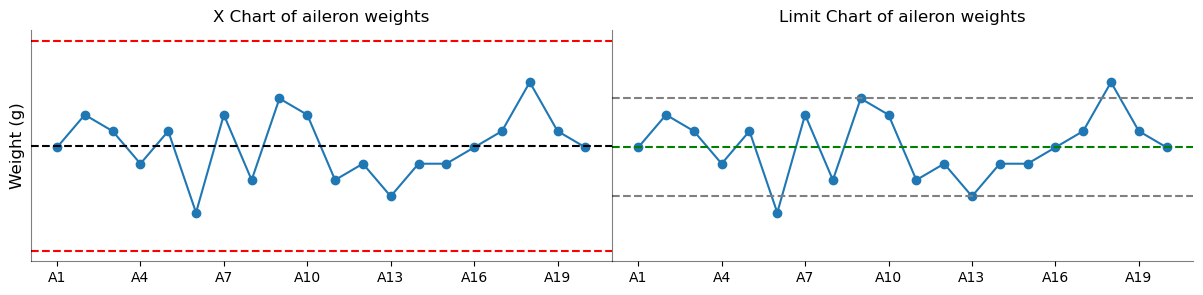

In [73]:
# Generate fig, ax
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,3), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0)

# Plot process behavior chart to ax[0]
ax[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add centerline and process limits 
for value, color in xchart_lines:
    ax[0].axhline(value, ls='--', c=color)
    
#Plot limit plot to ax[1]
ax[1].plot(labels, data, marker='o')

# Add centerline and process limits 
for value, color in limit_chart_lines:
    ax[1].axhline(value, ls='--', c=color)

# Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

ax[0].set_title('X Chart of aileron weights')
ax[1].set_title('Limit Chart of aileron weights')

ax[0].set_yticks([])

# Specify axis labels and title
# plt.xlabel("",fontsize=12)
ax[0].set_ylabel("Weight (g)", fontsize=12)
# plt.title("Process behavior chart of elevator weights", fontsize=14)

# Specify spine visibility 
sns.despine()
for value in range(0,2):
    ax[value].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()